# Notebook version of example_map_paper.py

(The blobby landmap.)

With some steps broken down.

In [1]:
import functools
import glob
import os

import lightgbm
import matplotlib
import numpy
from matplotlib import pyplot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from PIL import Image

import sksym

# use latex text / fonts to match document
# https://matplotlib.org/stable/tutorials/text/usetex.html
pyplot.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
    }
)

# image inputs are required; make them (if not already done)

In [2]:
!make data_map.log

make: 'data_map.log' is up to date.


# work functions to be used below...

In [3]:
def example_map(suffix, ndata, violate=None, filter_=None, *, nfakes=1):
    """Made data, fit a model, and output diagnostics."""
    print("suffix:", suffix, flush=True)

    images, heights = load_images()

    # build map from pixel to blob index
    shape = images[0].shape  # (y, x)
    pixel_index = numpy.empty(shape, numpy.int_)
    for i, img in enumerate(images):
        pixel_index[img] = i

    # make initial distribution scale with height
    dist = numpy.empty(shape, numpy.float_)
    min_height = min(heights)
    for i, img in enumerate(images):
        dist[img] = (heights[i] - min_height) ** 1.5

    # violate its symmetry
    if violate is not None:
        violate(dist)

    # apply filtering
    if filter_ is None:
        filt = numpy.ones(dist.shape)
    else:
        filt = filter_(dist.shape)
        dist *= filt

    map_cdf = dist.ravel().cumsum()
    map_cdf /= map_cdf[-1]

    # make un-violated distributions for contours
    cdfs = []
    for img in images:
        pdf = img * filt
        cdf = pdf.ravel().cumsum()
        if cdf[-1]:
            cdf /= cdf[-1]
        cdfs.append(cdf)

    # sample data (y, x)
    def sample_blob(cdf):
        # discrete cdf sample
        yxi = numpy.searchsorted(cdf, RNG.uniform())
        y = yxi // shape[1]
        x = yxi % shape[1]
        # assign within pixel
        y += RNG.uniform()
        x += RNG.uniform()
        return y, x

    data = numpy.empty((ndata * 2, 2))
    for i in range(len(data)):
        data[i] = sample_blob(map_cdf)

    x_train = data[:ndata]
    x_test = data[ndata:]

    # fit model
    def transform(data):
        new = numpy.empty_like(data)
        for i, (y0, x0) in enumerate(data):
            index = pixel_index[int(y0), int(x0)]
            new[i] = sample_blob(cdfs[index])
        return new

    blobber = sksym.WhichIsReal(transform, nfakes)

    model = lightgbm.LGBMRegressor(
        objective=blobber.objective(),
        max_depth=2,
        random_state=RNG.integers(2**31),
    )

    sksym.fit(model, blobber.pack(x_train))

    # score
    x_pack = blobber.pack(x_test)

    print("mean llr: %.3f +- %.3f" % sksym.score(model, x_pack, and_std=True))

    # figure: data (cut)

    # figure: classifier by blob (cut)
    scores = sksym.predict_log_proba(model, x_pack)[..., 0] - numpy.log(0.5)
    if nfakes > 1:
        scores = scores.mean(axis=0)
    blob_scores = numpy.zeros(len(images))
    for i, score in enumerate(scores):
        y, x = x_train[i]
        index = pixel_index[int(y), int(x)]
        blob_scores[index] += score

    blob_scores /= len(scores)

    influence = numpy.empty(shape)
    for i, bs in enumerate(blob_scores):
        img = images[i]
        influence[img] = bs

    # figure: model output (cut)
    ygrid = numpy.linspace(0, shape[0], 100)
    xgrid = numpy.linspace(0, shape[1], 200)
    xgrid, ygrid = numpy.meshgrid(xgrid, ygrid)

    grid = numpy.stack([ygrid.ravel(), xgrid.ravel()], axis=-1)
    zgrid = model.predict(grid).reshape(xgrid.shape)

    # figure: paper
    figure, (ax1, ax2, ax3) = pyplot.subplots(1, 3, dpi=600, figsize=(6, 1.8))
    figure.subplots_adjust(0.005, 0, 0.995, 0.95, 0.02, 0)

    # figure: paper: data
    ax1.scatter(
        x_train[:, 1],
        x_train[:, 0],
        c="k",
        s=1,
        marker=",",
        lw=0,
    )

    ax1.set_xlim(0, shape[1])
    ax1.set_ylim(shape[0], 0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_aspect("equal")

    # figure: paper: zeta
    vmin = min(zgrid.min(), -1)
    vmax = max(zgrid.max(), 1)

    cont = ax2.contourf(
        xgrid,
        ygrid,
        zgrid,
        cmap=CMAP,
        levels=numpy.linspace(vmin, vmax, 255),
    )

    width = "80%"
    height = "5%"
    pad = -0.8
    ax2in = inset_axes(
        ax2, width=width, height=height, loc="upper center", borderpad=pad
    )

    ax2cb = figure.colorbar(
        cont,
        cax=ax2in,
        orientation="horizontal",
        ticklocation="top",
        ticks=[-1, 1],
    )
    ax2cb.ax.tick_params(length=2, pad=1)

    ax2.set_xlim(0, shape[1])
    ax2.set_ylim(shape[0], 0)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel(r"$\zeta(x)$", labelpad=2)
    ax2.set_aspect("equal")

    # figure: paper: orbit score
    size = 0.007
    im = ax3.imshow(
        influence,
        vmin=-size,
        vmax=size,
        cmap=CMAP,
        interpolation="None",
    )

    ax3in = inset_axes(
        ax3, width=width, height=height, loc="upper center", borderpad=pad
    )
    ax3cb = figure.colorbar(
        im,
        cax=ax3in,
        orientation="horizontal",
        ticklocation="top",
        ticks=[-size, size],
    )
    ax3cb.ax.tick_params(length=2, pad=1)

    ax3.set_xlim(0, shape[1])
    ax3.set_ylim(shape[0], 0)
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax3.set_xlabel(r"$Q_i$", labelpad=2)
    ax3.set_aspect("equal")

    pyplot.show()


@functools.cache
def load_images():
    """Return lists of input images and height values."""
    images = []
    heights = []
    shape = None
    for path in glob.glob("data_map/mask_*_*.png"):
        img = numpy.array(Image.open(path))
        if shape is None:
            shape = img.shape
        assert img.shape == shape
        assert img.dtype == numpy.bool_
        images.append(img)
        heights.append(int(path.split("_")[-2]))
    return images, heights


## globals

In [4]:
RNG = numpy.random.Generator(numpy.random.Philox(0xF00D))

CMAP = matplotlib.cm.inferno

NDATA = 5_000

# main function expanded

In [5]:
def violate(scale, dist):
    x = numpy.linspace(1, 10, dist.shape[1])
    dist *= 1 - scale * numpy.sin(x) ** 2

def wave(dist):
    for i in range(dist.shape[0]):
        rot = int(numpy.sin(i / 20) * 100)
        dist[i] = numpy.roll(dist[i], rot)

def filter_(shape):
    ngap = 30
    scale = 0.2
    filt = numpy.ones(shape)
    filt[:ngap] = scale
    filt[-ngap:] = scale
    filt[:, :ngap] = scale
    filt[:, -ngap:] = scale
    return filt

def seasons(d):
    return violate(frac, d)

# main: first experiment obeying symmetry

suffix: 5k_0p0_filtered
mean llr: -0.002 +- 0.001


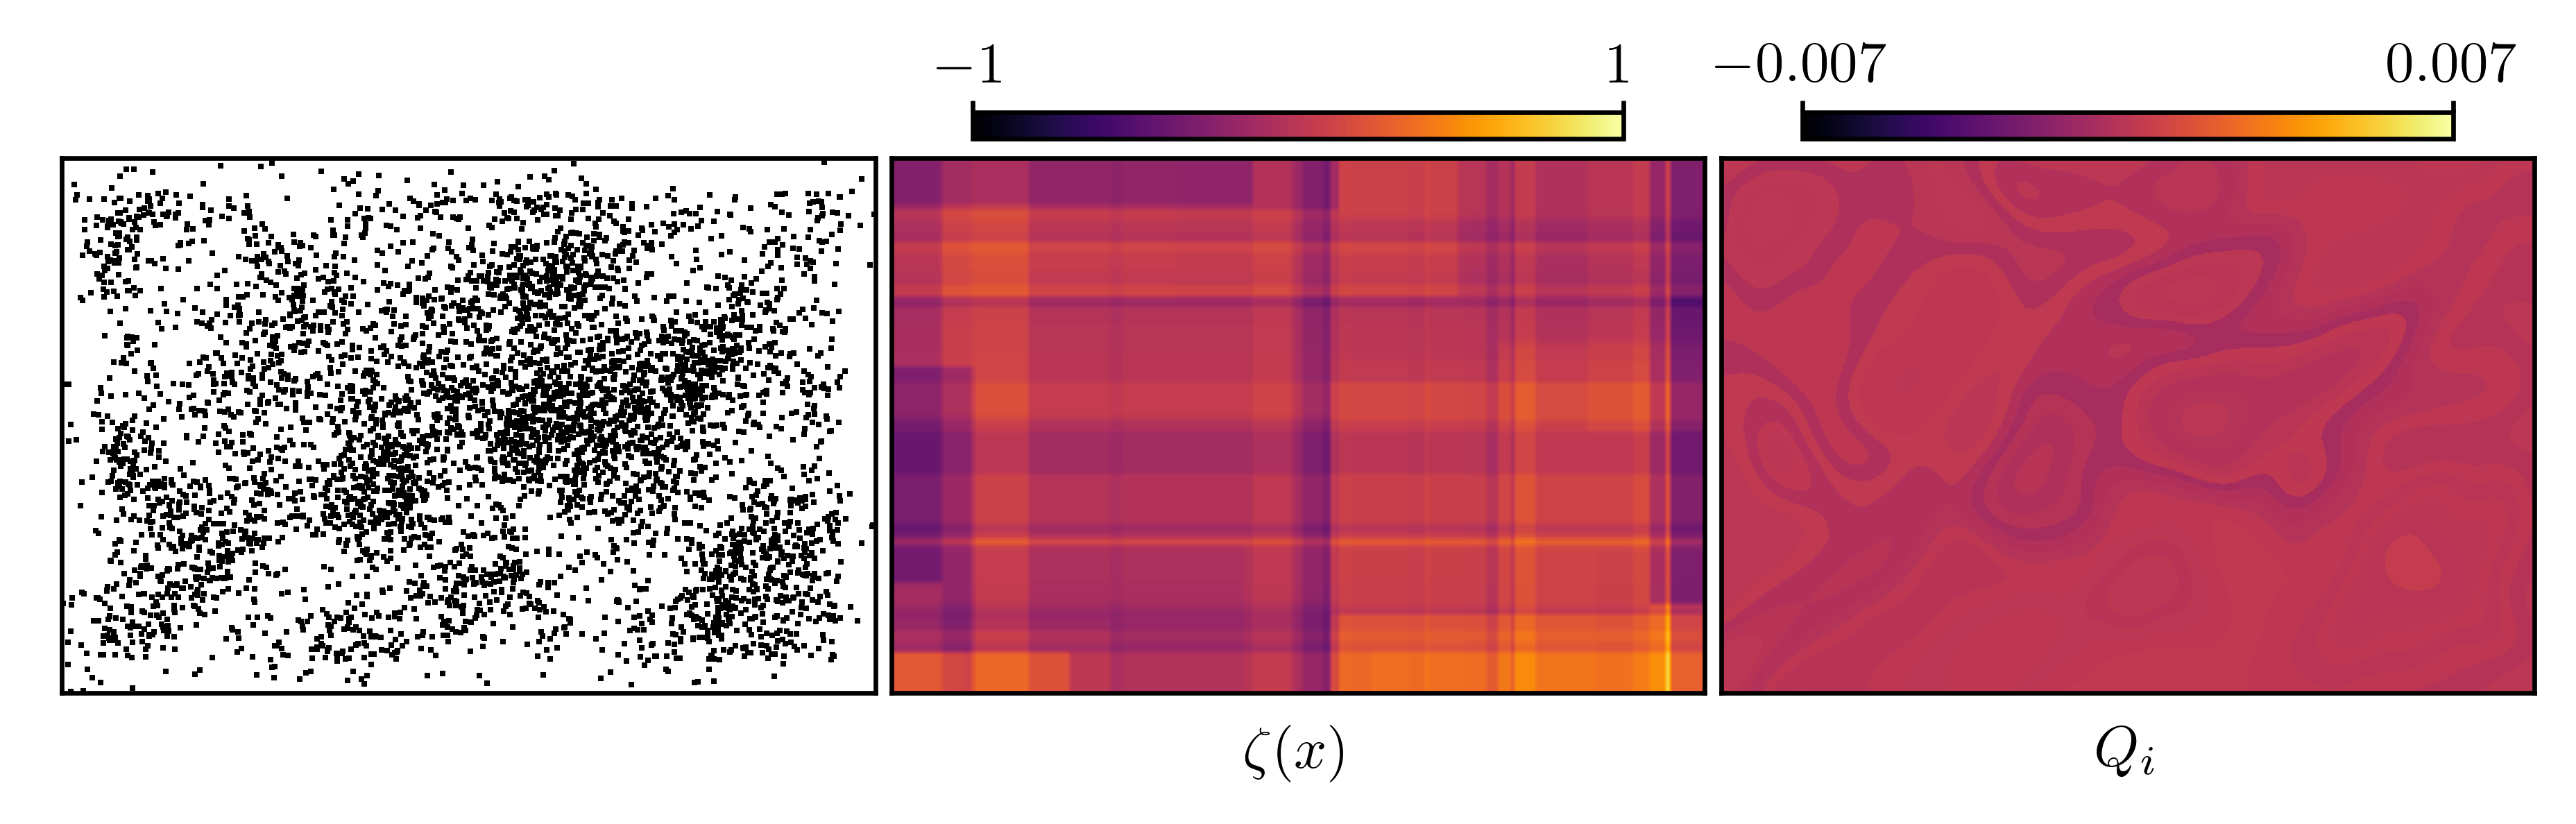

In [6]:
frac = 0.0
suffix = "%dk_%.1f_filtered" % (NDATA // 1000, frac)
suffix = suffix.replace(".", "p")

example_map(suffix, NDATA, seasons, filter_)

# main: second experiment perturbing with waves

suffix: 5k_0p9_filtered
mean llr: 0.066 +- 0.004


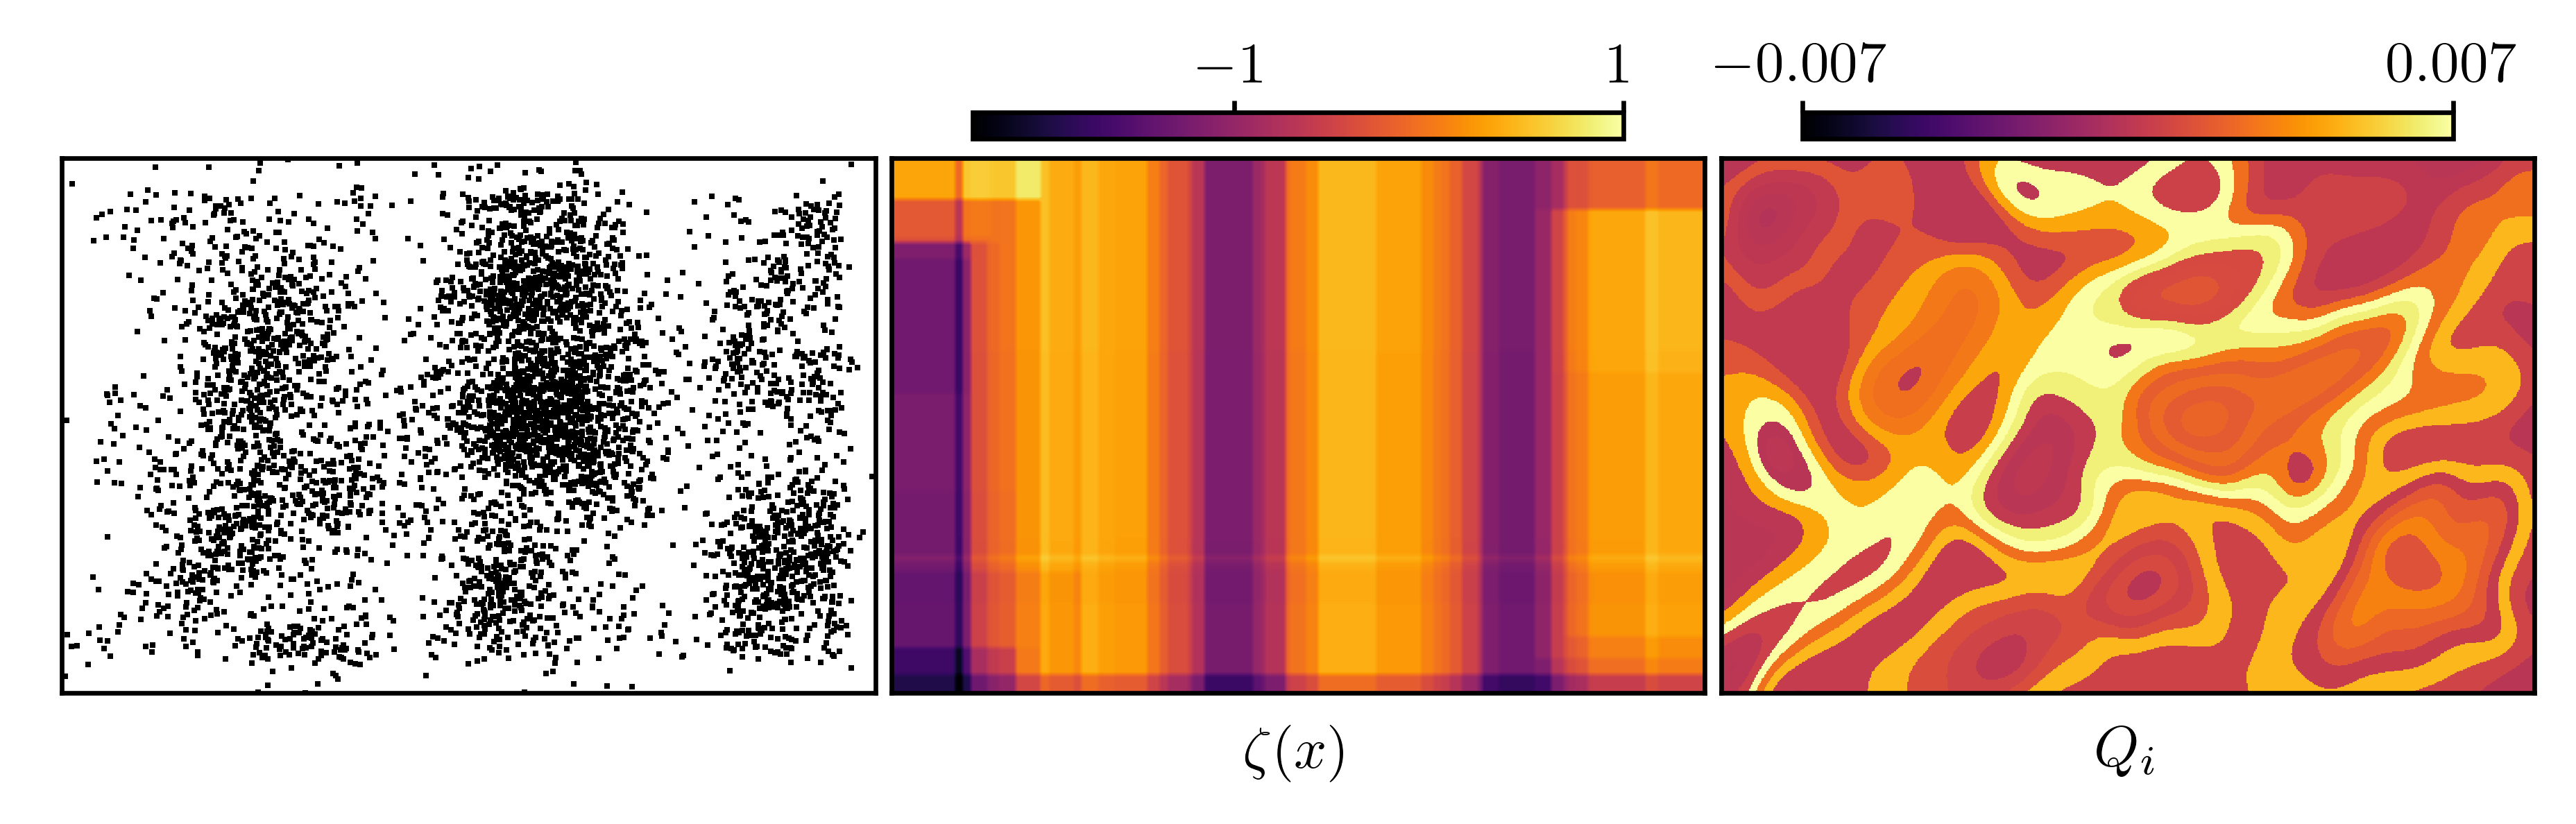

In [7]:
frac = 0.9
suffix = "%dk_%.1f_filtered" % (NDATA // 1000, frac)
suffix = suffix.replace(".", "p")
example_map(suffix, NDATA, seasons, filter_)